<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/MultilayeredStructures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [2]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2019.1.0


#Load pre-defined functions

In [3]:
import sympy as sp  
exists = os.path.isfile('DmriFemBuitInFunc.py')
isupdate = False
if (exists==False or isupdate==True):
    if isupdate==True:
        !rm DmriFemBuitInFunc.py
    print("Load pre-defined functions from GitHub")
    !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/DmriFemBuitInFunc.py
from DmriFemBuitInFunc import *
      

Load pre-defined functions from GitHub


# Working on the mesh and submesh

Extracting cell markers from: multi_layered_torus.msh ...
Extracted successfully on: 55656 elements
Partition marker list: ['0', '1', '2']
Wrote to: pmk_multi_layered_torus.xml
Partition markers: [0, 1, 2]


DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:not adjusting title pos because title was already placed manually: 0.920000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title 

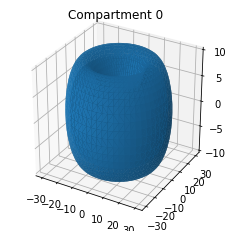

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:not adjusting title pos because title was already placed manually: 0.920000
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


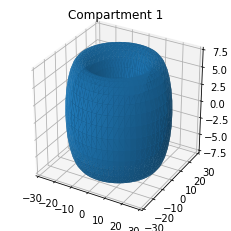

In [4]:
geo_choice = 2
################################################################################
############## Create two-layered disk using mshr in FEniCS ####################
if geo_choice == 1:
    R1, R2 = 5, 10;
    origin = Point(0.,0.)
    circle = Circle(origin, R1, segments=32)
    domain = Circle(origin, R2, segments=32)
    domain.set_subdomain(1, circle)
    mymesh = generate_mesh(domain, 15) # 15 is the resolution
    cmpt_mesh = generate_mesh(circle, 15)
    cellmarker, phase, partition_marker, partion_list = Create_phase_func(mymesh, cmpt_mesh, None)    

################################################################################
############## Create multilayered domains using gmsh ##########################
if geo_choice == 2:
    # mesh_name = "multi_layered_disk"
    # mesh_name = "multi_layered_cylinder"
    # mesh_name = "multi_layered_sphere"
    mesh_name = "multi_layered_torus"
    is_partition_function_exist = os.path.isfile('GetPartitionMarkers.py')
    if is_partition_function_exist==False:
        !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/GetPartitionMarkers.py

    is_geo_file_exist = os.path.isfile(mesh_name+'.geo')  
    if is_geo_file_exist==False:
        !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/$mesh_name''.geo

    # Modify .geo file from 4 layers to 3 layers      
    !sed -i 's/5, 7.5, 10, 13/5, 7.5, 10/g' $mesh_name''.geo
      
    # Create mesh from geo file by gmsh
    !gmsh -3 $mesh_name''.geo -o $mesh_name''.msh
    
    # Convert .msh to .xml using dolfin-convert
    !dolfin-convert $mesh_name''.msh $mesh_name''.xml
    clear_output()

    mymesh = Mesh(mesh_name+".xml");  

    from GetPartitionMarkers import *

    GetPartitionMarkers(mesh_name+".msh", "pmk_"+mesh_name+".xml")

    partition_marker = MeshFunction("size_t", mymesh, mymesh.topology().dim())

    File("pmk_"+mesh_name+".xml")>>partition_marker

    cellmarker, phase, partition_marker, partion_list = Create_phase_func(mymesh, None, partition_marker)    

################################################################################
############## Download the existing mesh and submesh ##########################
if geo_choice == 3:
    is_file_exist = os.path.isfile("multi_layer_torus.xml")  
    if is_file_exist==False:
        !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/comri/meshes/multi_layer_torus.xml.zip
        !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/comri/meshes/multi_layer_torus_compt1.xml.zip
        !unzip -q multi_layer_torus.xml.zip
        !unzip -q multi_layer_torus_compt1.xml.zip

    mymesh = Mesh("multi_layer_torus.xml");  
    cmpt_mesh = Mesh('multi_layer_torus_compt1.xml')
    cellmarker, phase, partition_marker, partion_list = Create_phase_func(mymesh, cmpt_mesh, None)    
    
################################################################################
############## Save, Plot phase functions and submeshes to verify ##############
print("Partition markers:", partion_list)
if mymesh.topology().dim()==2:
    print(cellmarker, partition_marker)
    plt.subplot(1, 2, 1); plot(cellmarker, cmap="coolwarm", title="Cell marker");
    plt.subplot(1, 2, 2); plot(partition_marker, cmap="coolwarm",  title="Partition marker");
mesh0 = SubMesh(mymesh, cellmarker, 0)
mesh1 = SubMesh(mymesh, cellmarker, 1)
File("Phase.pvd")<<phase
File("mesh0.xml")<<mesh0
File("mesh1.xml")<<mesh1
plt.figure(2); plot(mesh0, title="Compartment 0") 
plt.figure(3); plot(mesh1, title="Compartment 1")

# Solve the Bloch-Torrey equation

Function Space for Two-compartment Domains has 4 components
(ur0, ui0, ur1, ur1): r-real, i-imaginary
Initialize a standard function space.
Impose Diffusion Tensor
[
  [f_29090, f_29093, f_29096],
  [f_29099, f_29102, f_29105],
  [f_29108, f_29111, f_29114]
]
t:   0.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 0.00%
t: 1000.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 1.86%
t: 2000.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 3.71%
t: 3000.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 5.57%
t: 4000.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 7.42%
t: 5000.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 9.28%
t: 6000.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 11.13%
t: 7000.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 12.99%
t: 8000.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 14.84%
t: 9000.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 16.70%
t: 10000.00  T: 53700.00 dt: 200.0 gn

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


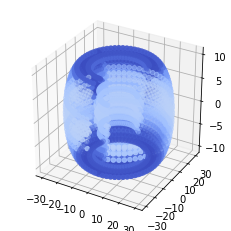

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


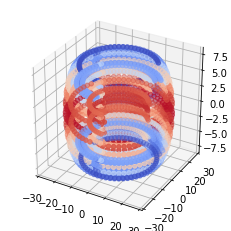

In [8]:
mri_simu = MRI_simulation()
mri_para = MRI_parameters()

bvalues = [1000]

for bvalue in bvalues:
    #################################################################################
    #########################  Pre-defined parameters ###############################
    mri_para.bvalue = bvalue                             # bvalue
    mri_para.delta, mri_para.Delta = 10600, 43100        # time sequence
    mri_para.set_gradient_dir(mymesh, 0, 0, 1)           # gradient direction
    mri_para.T = mri_para.Delta+mri_para.delta
    mri_para.fs_sym = sp.Piecewise(
                    (  1., mri_para.s < mri_para.delta ),
                    (  0., mri_para.s < mri_para.Delta ),
                    ( -1., mri_para.s < mri_para.T ),
                    (  0., True )  
                ) 

    mri_para.Apply()
    mri_simu.k = 200;                                    # time-step size
    mri_simu.nskip = 5;                                  # frequency to print ouputs

    mydomain = MyDomain(mymesh, mri_para)
    mydomain.phase = phase
    mydomain.mesh0 = mesh0
    mydomain.mesh1 = mesh1
    mydomain.PeriodicDir = [0, 0, 0];            # Direction of the periodicity
    mydomain.IsDomainPeriodic = False             # Confirm if the mesh if periodic
    mydomain.IsDomainMultiple = True             # Confirm if the mesh is multiple
    mydomain.kappa = 1e-5                        # Permeability
    ################################################################################

    mydomain.Apply()   # Call Apply before setting the diffusion tensor

    ################################################################################
    # Impose the diffusion coefficient
    mydomain.D0 = 3e-3
    D0_array=[mydomain.D0, mydomain.D0/3, mydomain.D0]

    # Variable tensor
    dofmap_DG = mydomain.V_DG.dofmap()
    d00 = Function(mydomain.V_DG); d01 = Function(mydomain.V_DG); d02 = Function(mydomain.V_DG)
    d10 = Function(mydomain.V_DG); d11 = Function(mydomain.V_DG); d12 = Function(mydomain.V_DG)
    d20 = Function(mydomain.V_DG); d21 = Function(mydomain.V_DG); d22 = Function(mydomain.V_DG)

    for cell in cells(mymesh):
        p = cell.midpoint() # the coordinate of the cell center.
        cmk = partition_marker[cell.index()]
        cell_dof = dofmap_DG.cell_dofs(cell.index())
        d00.vector()[cell_dof] = D0_array[cmk]; 
        d11.vector()[cell_dof] = D0_array[cmk]; 
        d22.vector()[cell_dof] = D0_array[cmk];

    mydomain.ImposeDiffusionTensor(d00, d01, d02, d10, d11, d12, d20, d21, d22)
    #################################################################################
    #################################################################################

    # linsolver = PETScLUSolver("mumps")
    linsolver = KrylovSolver("bicgstab")
    #linsolver.parameters["absolute_tolerance"] = 1e-4
    #linsolver.parameters["relative_tolerance"] = 1e-3
    #linsolver.parameters["maximum_iterations"] = 1000

    mri_simu.solve(mydomain, mri_para, linsolver)

    ctext = ''
    if bvalue == 1000:
        ctext = 'Torus R=[5, 7.5, 10], Delta=43.1ms, delta=10.6ms, D=[3 1 3]*1e-3 mm^2/s, kappa=1e-5m/s, gdir=100'
    Post_processing(mydomain, mri_para, mri_simu, ctext)


# Reference solutions

In [0]:
# The results were generated by the Matrix Formalism method propsed in
# D.S. Grebenkov, Pulsed-gradient spin-echo monitoring of restricted 
# diffusion in multilayered structures, J. Magn. Reson., 205 (2) (2010)


# # # # # # # # # # # # # # # # D.I.S.K # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # R=[5,7.5,10], PGSE delta=Delta=40000 # # # ## # # # # # # # # #
# # # # # # # # # # mydomain.PeriodicDir = [0, 0, 0];
# D=3e-3 mm^2/s, kappa=5e-5m/s
#  bvalue    # signal attenuation
#  0.000e+00 #  1.000e+00
#  1.000e+03 #  7.181e-01
#  2.000e+03 #  5.234e-01
#  3.000e+03 #  3.899e-01
#  4.000e+03 #  2.990e-01
#  5.000e+03 #  2.373e-01
#  6.000e+03 #  1.952e-01
#  7.000e+03 #  1.661e-01
#  8.000e+03 #  1.454e-01
#  9.000e+03 #  1.302e-01
#  1.000e+04 #  1.184e-01
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# D=[3 1 3]*1e-3 mm^2/s, kappa=1e-5m/s
#  0.000e+00 # 1.000e+00
#  1.000e+03 # 7.297e-01
#  2.000e+03 # 5.525e-01
#  3.000e+03 # 4.381e-01
#  4.000e+03 # 3.649e-01
#  5.000e+03 # 3.181e-01
#  6.000e+03 # 2.877e-01
#  7.000e+03 # 2.672e-01
#  8.000e+03 # 2.522e-01
#  9.000e+03 # 2.402e-01
#  1.000e+04 # 2.297e-01
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #



# # # # # # # # # # # # # # # S.P.H.E.R.E # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # R=[5,7.5,10], PGSE delta=Delta=40000 # # # # # # # #  # # # #
# # # # # # # # # # mydomain.PeriodicDir = [0, 0, 0];
# D=3e-3 mm^2/s, kappa=5e-5m/s
#  bvalue    # signal attenuation
#  0.000e+00 #  1.000e+00
#  1.000e+03 #  7.886e-01
#  2.000e+03 #  6.228e-01
#  3.000e+03 #  4.932e-01
#  4.000e+03 #  3.921e-01
#  5.000e+03 #  3.135e-01
#  6.000e+03 #  2.526e-01
#  7.000e+03 #  2.054e-01
#  8.000e+03 #  1.688e-01
#  9.000e+03 #  1.406e-01
#  1.000e+04 #  1.186e-01
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# D=[3 1 3]*1e-3 mm^2/s
#  0.000e+00 #  1.000e+00
#  1.000e+03 #  7.707e-01
#  2.000e+03 #  5.932e-01
#  3.000e+03 #  4.565e-01
#  4.000e+03 #  3.518e-01
#  5.000e+03 #  2.721e-01
#  6.000e+03 #  2.117e-01
#  7.000e+03 #  1.662e-01
#  8.000e+03 #  1.321e-01
#  9.000e+03 #  1.065e-01
#  1.000e+04 #  8.749e-02
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


# # # # # # # # # # # # # # # C.Y.L.I.N.D.E.R # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # R=[5,7.5,10], PGSE delta=Delta=10000 # # # # # # # #  # # # #
# D=3e-3 mm^2/s, kappa=5e-5m/s
# gdir=[0, 1, 0]:
# 0.000e+00 #  1.000e+00
# 1.000e+03 #  4.777e-01
# 2.000e+03 #  2.996e-01
# 3.000e+03 #  2.235e-01
# 4.000e+03 #  1.784e-01
# 5.000e+03 #  1.455e-01
# 6.000e+03 #  1.200e-01
# 7.000e+03 #  1.003e-01
# 8.000e+03 #  8.513e-02
# 9.000e+03 #  7.374e-02
# 1.000e+04 #  6.531e-02
# gdir=[1, 0, 0]:
# mydomain.PeriodicDir = [1, 0, 0]: s=exp(-bvalue*D0)
# mydomain.PeriodicDir = [0, 0, 0]:
#  bvalue    # signal attenuation
#  0.000e+00 #  1.000e+00
#  1.000e+03 #  2.588e-01
#  2.000e+03 #  1.191e-01
#  3.000e+03 #  8.646e-02
#  4.000e+03 #  6.591e-02
#  5.000e+03 #  5.008e-02
#  6.000e+03 #  4.019e-02
#  7.000e+03 #  3.460e-02
#  8.000e+03 #  3.083e-02
#  9.000e+03 #  2.738e-02
#  1.000e+04 #  2.390e-02
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #